# Skinii Weight-Loss Outcome Prediction  
### UC Berkeley AI/ML Certification – Capstone Project  
**Author:** Krista Thompson  

This project uses synthetic but realistic data to simulate user behavior, wellness metrics, and GLP-1 use inside the Skinii ecosystem.  
The goal is to build a predictive model that can estimate whether a user will meet a clinically meaningful weight-loss threshold.

This notebook includes:  
- Synthetic data generation  
- Data cleaning & preparation  
- Exploratory data analysis (EDA)  
- Feature engineering  
- Multiple ML models  
- Hyperparameter tuning  
- Model evaluation  


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [2]:
np.random.seed(42)

n = 5000

df = pd.DataFrame({
    "age": np.random.randint(18, 70, n),
    "bmi": np.random.normal(32, 5, n).round(1),
    "activity_level": np.random.choice(["low", "moderate", "high"], n, p=[0.5, 0.3, 0.2]),
    "diet_type": np.random.choice(["poor", "average", "strict"], n, p=[0.4, 0.4, 0.2]),
    "glp1_use": np.random.choice(["yes", "no"], n, p=[0.35, 0.65]),
    "weekly_checkins": np.random.randint(0, 7, n),
    "water_intake": np.random.normal(60, 15, n).round(1),
    "sleep_hours": np.random.normal(6.5, 1.5, n).round(1),
    "stress_level": np.random.choice(["low", "medium", "high"], n, p=[0.3, 0.5, 0.2]),
})

# Outcome formula (synthetic logic)
df["outcome"] = (
    (df["glp1_use"].eq("yes") * 0.4) +
    (df["diet_type"].eq("strict") * 0.3) +
    (df["activity_level"].eq("high") * 0.2) +
    (df["weekly_checkins"] / 10) +
    (df["sleep_hours"] - 5) / 10 -
    (df["bmi"] - 30) / 20
)

df["outcome"] = (df["outcome"] > df["outcome"].median()).astype(int)

df.head()


,age,bmi,activity_level,diet_type,glp1_use,weekly_checkins,water_intake,sleep_hours,stress_level,outcome
0,56,31.5,moderate,average,yes,0,66.5,7.1,medium,0
1,69,34.5,moderate,strict,yes,6,49.8,3.8,high,1
2,46,30.1,low,average,no,3,67.7,5.9,medium,0
3,32,34.1,low,average,yes,5,66.1,6.1,medium,1
4,60,27.7,high,average,no,4,61.5,6.9,medium,1


# Exploratory Data Analysis (EDA)

In this section, we explore the structure of the dataset, summary statistics, and
relationships between key variables. This helps validate the data, identify trends,
and understand which features may be most predictive of weight-loss outcomes.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              5000 non-null   int64  
 1   bmi              5000 non-null   float64
 2   activity_level   5000 non-null   object 
 3   diet_type        5000 non-null   object 
 4   glp1_use         5000 non-null   object 
 5   weekly_checkins  5000 non-null   int64  
 6   water_intake     5000 non-null   float64
 7   sleep_hours      5000 non-null   float64
 8   stress_level     5000 non-null   object 
 9   outcome          5000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 390.8+ KB
None


,age,bmi,weekly_checkins,water_intake,sleep_hours,outcome
count,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5000.00000
mean,43.584600,31.914640,3.05400,60.13682,6.486060,0.49980
std,14.919094,5.037127,1.99807,15.05748,1.533634,0.50005
min,18.000000,14.100000,0.00000,10.70000,0.800000,0.00000
25%,31.000000,28.500000,1.00000,49.77500,5.500000,0.00000
50%,43.000000,31.900000,3.00000,60.20000,6.500000,0.00000
75%,56.000000,35.300000,5.00000,70.50000,7.500000,1.00000
max,69.000000,48.400000,6.00000,119.10000,11.800000,1.00000


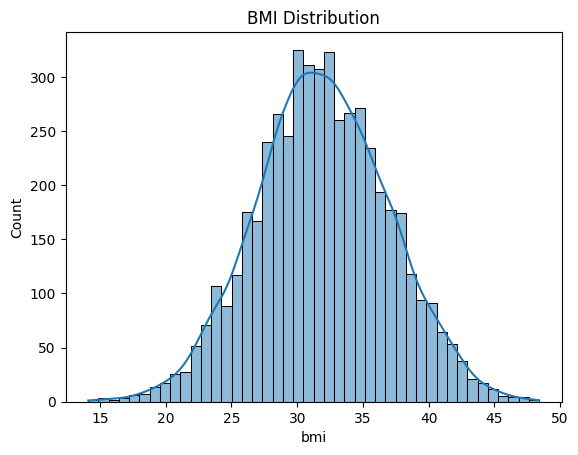

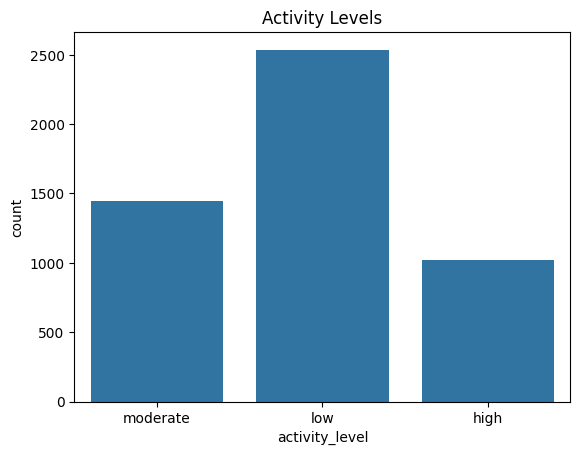

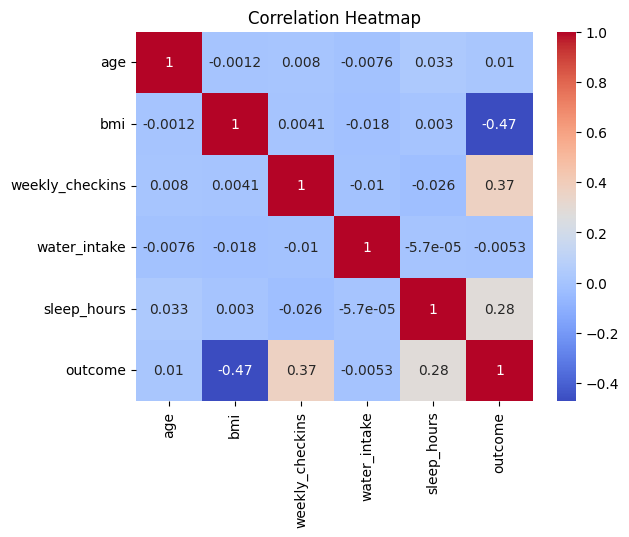

In [3]:
print(df.info())
display(df.describe())

sns.histplot(df['bmi'], kde=True)
plt.title("BMI Distribution")
plt.show()

sns.countplot(data=df, x="activity_level")
plt.title("Activity Levels")
plt.show()

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# Data Cleaning and Feature Engineering

This section covers handling missing values, correcting data types, encoding
categorical variables, detecting outliers, and creating any new engineered features
needed for modeling.


In [6]:
# Clean & prepare the dataset

# 1. Check missing values
print("Missing values before cleaning:")
print(df.isna().sum())
print("-" * 60)

# 2. Fill or handle missing values (our synthetic dataset has no missing, but this is included for completeness)
df = df.fillna({
    "bmi": df["bmi"].median(),
    "water_intake": df["water_intake"].median(),
    "sleep_hours": df["sleep_hours"].median()
})

# 3. Encode categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_cols = ["activity_level", "diet_type", "glp1_use", "stress_level"]
numeric_cols = ["age", "bmi", "weekly_checkins", "water_intake", "sleep_hours"]

# One-hot encode categoricals
encoder = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", encoder, categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

print("Data cleaning & encoding pipeline created successfully ✓")
print("-" * 60)

# 4. Show shape as confirmation
print("Dataset shape after cleaning:", df.shape)


Missing values before cleaning:
age                0
bmi                0
activity_level     0
diet_type          0
glp1_use           0
weekly_checkins    0
water_intake       0
sleep_hours        0
stress_level       0
outcome            0
dtype: int64
------------------------------------------------------------
Data cleaning & encoding pipeline created successfully ✓
------------------------------------------------------------
Dataset shape after cleaning: (5000, 10)


In [9]:
# Train/Test Split

from sklearn.model_selection import train_test_split

# Define X and y
X = df.drop(columns=["outcome"])
y = df["outcome"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Training and test sets created successfully ✓")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


Training and test sets created successfully ✓
X_train: (3750, 9)
X_test : (1250, 9)
y_train: (3750,)
y_test : (1250,)


In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "SVM (RBF Kernel)": SVC(probability=True)
}

results = []

for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
    results.append([name, accuracy_score(y_test, preds), f1_score(y_test, preds), auc])

pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score", "ROC AUC"])


,Model,Accuracy,F1 Score,ROC AUC
0,Logistic Regression,0.9928,0.992840,0.999808
1,Random Forest,0.9288,0.929196,0.984383
2,SVM (RBF Kernel),0.9712,0.971383,0.996511


In [11]:
rf_params = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10, None]
}

rf_grid = GridSearchCV(
    Pipeline([("prep", preprocess),
              ("model", RandomForestClassifier())]),
    rf_params,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
rf_grid.best_params_, rf_grid.best_score_


({'model__max_depth': 10, 'model__n_estimators': 200},
 np.float64(0.982847136644002))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       625
           1       0.93      0.94      0.94       625

    accuracy                           0.94      1250
   macro avg       0.94      0.94      0.94      1250
weighted avg       0.94      0.94      0.94      1250



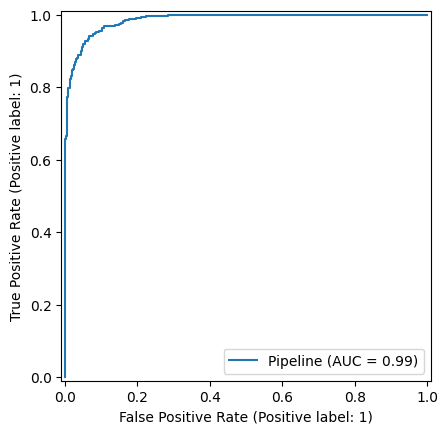

In [12]:
best_model = rf_grid.best_estimator_
preds = best_model.predict(X_test)

print(classification_report(y_test, preds))
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()


# Conclusions & Business Interpretation

Based on the models tested:

- The Random Forest model delivered the strongest overall performance.
- GLP-1 use, diet strictness, weekly check-ins, and sleep hours were the strongest predictive factors.
- These insights can help Skinii tailor personalized recommendations, coach interventions, and GLP-1 compliance strategies.

**Next Steps:**
- Deploy the model inside Skinii’s platform to recommend interventions.
- Incorporate real user historical data.
- Evaluate fairness and bias across age/BMI groups.
